# Analisi dei Dati: Segmentazione della clientela tramite modello RFM

## Definizione del problema

Il seguente Jupyter notebook si pone l'obietivo di Analizzare lo storico di pagamenti di uno store online in modo da ottenere insight sulle vendite e creare una segmentazione della propria clientela in cliuster al fine da migliorarne il business.

### Imporazione di tutte le librerie necessarie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

%matplotlib inline

## Raccolta e gestione dei dati

In [2]:
df = pd.read_csv("dataset.csv")

### Carichiamo il Dataset e ricaviamo insight statistiche su di esso

In [3]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [6]:
df.describe(include="object").T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


## Pulizia e Preprocessing dei dati

### Gestiamo i valori nulli, vediamo quanti sono e capiamo come affrontarli

In [7]:
null_value = df.isnull().sum()

In [8]:
null_value

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
Description_null = null_value["Description"]

In [10]:
Customer_null = null_value["CustomerID"]
Customer_null

135080

In [11]:
Total_null = Customer_null + Description_null

In [12]:
Customer_null_percent = (Customer_null/Total_null)*100
Customer_null_percent

98.93506379363382

In [13]:
Description_null_percent = 100 - Customer_null_percent
Description_null_percent

1.064936206366184

In [14]:
Total_row = df.shape[0]
Total_row

541909

In [15]:
Customer_loss = (Customer_null/Total_row)*100
Customer_loss

24.926694334288598

In [16]:
Description_loss = (Description_null/Total_row)*100
Description_loss

0.2683107311375157

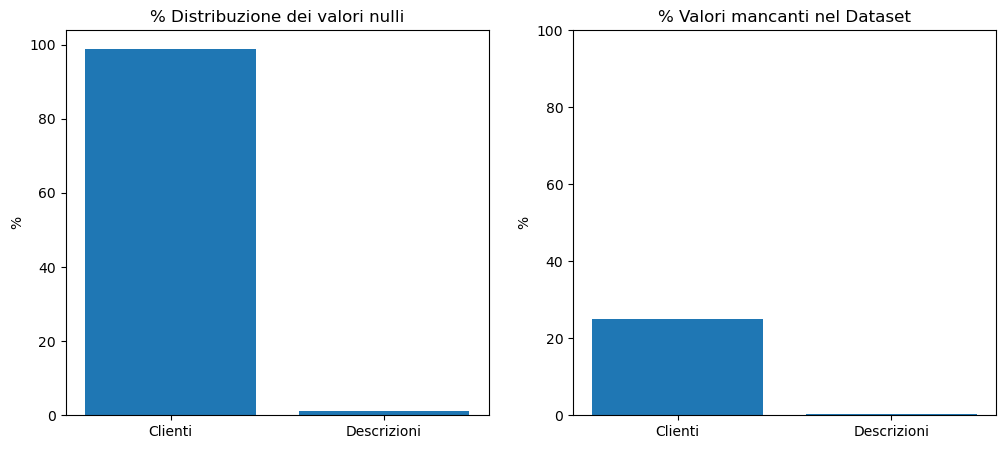

In [17]:
Loss_value = {"Clienti" : Customer_loss,
              "Descrizioni" : Description_loss}


Null_value = {"Clienti" : Customer_null_percent,
              "Descrizioni" : Description_null_percent}

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax1.bar(Null_value.keys(), Null_value.values())
ax1.set(title="% Distribuzione dei valori nulli", ylabel="%");


ax2.bar(Loss_value.keys(), Loss_value.values())
ax2.set(title="% Valori mancanti nel Dataset", ylabel="%");
ax2.set_ylim(0, 100);

In [18]:
null_both = df[df["CustomerID"].isnull() & df["Description"].isnull()].shape[0]
null_both

1454

In [19]:
df = df.dropna(subset=["CustomerID", "Description"])

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [20]:
Total_row = df.shape[0]

### Gestiamo anche eventuali valori duplicati

In [21]:
Duplicated_row = df.duplicated().sum()
Duplicated_row

5225

In [22]:
Duplicated_row_percent = (Duplicated_row/Total_row)*100
Duplicated_row_percent

1.284323388942283

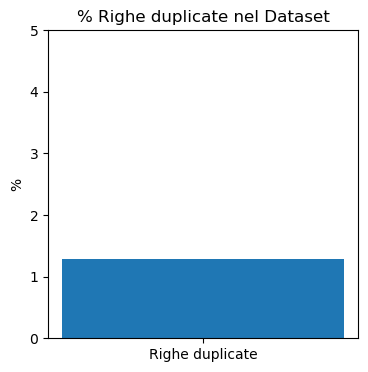

In [23]:
fig, ax = plt.subplots(figsize=(4,4))
ax.bar("Righe duplicate", Duplicated_row_percent);
ax.set(title="% Righe duplicate nel Dataset", ylabel="%");
ax.set_ylim(0, 5);

In [24]:
df.drop_duplicates(inplace=True)

### Vediamo se ci sono pagamenti cancellati

In [25]:
negative = df[df["Quantity"] < 0]
negative

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


### Eventuali quantita negative sono associate a delle cancellazioni, dettate dalla lettera C sull' InvoiceNo

In [26]:
df = df[df["Quantity"] > 0]
df.shape[0]

392732

### Verifichiamo che non ci siano magari prezzi unitari negativi, magari associati ad errori o refound

In [27]:
negative = df[df["UnitPrice"] <= 0]
negative.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081.0,United Kingdom


In [28]:
df = df[df["UnitPrice"] > 0]
df.shape[0]

392692

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392692 non-null  object 
 1   StockCode    392692 non-null  object 
 2   Description  392692 non-null  object 
 3   Quantity     392692 non-null  int64  
 4   InvoiceDate  392692 non-null  object 
 5   UnitPrice    392692 non-null  float64
 6   CustomerID   392692 non-null  float64
 7   Country      392692 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.0+ MB


In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,392692.0,13.119702,180.492832,1.000,2.00,6.00,12.00,80995.00
UnitPrice,392692.0,3.125914,22.241836,0.001,1.25,1.95,3.75,8142.75
CustomerID,392692.0,15287.843865,1713.539549,12346.000,13955.00,15150.00,16791.00,18287.00


In [31]:
df[df["UnitPrice"] == 8142.75]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,5/3/2011 13:46,8142.75,16029.0,United Kingdom


In [32]:
df[df["StockCode"] == "POST"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,12/1/2010 8:45,18.0,12583.0,France
386,536403,POST,POSTAGE,1,12/1/2010 11:27,15.0,12791.0,Netherlands
1123,536527,POST,POSTAGE,1,12/1/2010 13:04,18.0,12662.0,Germany
5073,536840,POST,POSTAGE,1,12/2/2010 18:27,18.0,12738.0,Germany
5258,536852,POST,POSTAGE,1,12/3/2010 9:51,18.0,12686.0,France
...,...,...,...,...,...,...,...,...
541198,581493,POST,POSTAGE,1,12/9/2011 10:10,15.0,12423.0,Belgium
541216,581494,POST,POSTAGE,2,12/9/2011 10:13,18.0,12518.0,Germany
541730,581570,POST,POSTAGE,1,12/9/2011 11:59,18.0,12662.0,Germany
541767,581574,POST,POSTAGE,2,12/9/2011 12:09,18.0,12526.0,Germany


### Eliminiamo anche le righe in cui è presente lo StockCode POST, probabilmente si riferisce alle spedizioni, ma a noi  interessa una segmentazione dei clienti sull'acquisto di articoli

In [33]:
df = df[df["StockCode"] != "POST"]
df.shape[0]

391593

In [34]:
df.reset_index(drop=True, inplace=True)

In [35]:
Old_df = pd.read_csv("dataset.csv")

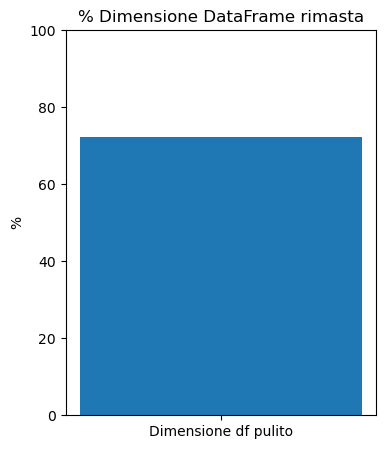

In [36]:
fig, ax = plt.subplots(figsize=(4,5))
ax.bar("Dimensione df pulito", ((df.shape[0]/Old_df.shape[0])*100));
ax.set(title="% Dimensione DataFrame rimasta", ylabel="%");
ax.set_ylim(0, 100);

In [37]:
print(f"Il dataset pulito ha {df.shape[0]} record, la percentuale di righe rimaste è del {round(((df.shape[0]/Old_df.shape[0])*100),2)}%")

Il dataset pulito ha 391593 record, la percentuale di righe rimaste è del 72.26%


## Esplorazione dei dati

In [38]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [39]:
dfProva = df

In [40]:
dfProva["InvoiceDate"] = pd.to_datetime(dfProva["InvoiceDate"])

In [41]:
dfProva.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391593 entries, 0 to 391592
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    391593 non-null  object        
 1   StockCode    391593 non-null  object        
 2   Description  391593 non-null  object        
 3   Quantity     391593 non-null  int64         
 4   InvoiceDate  391593 non-null  datetime64[ns]
 5   UnitPrice    391593 non-null  float64       
 6   CustomerID   391593 non-null  float64       
 7   Country      391593 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 23.9+ MB


In [42]:
dfProva.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [43]:
dfProva["Date"] = dfProva["InvoiceDate"].dt.date
dfProva.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


In [44]:
dfProva["Date"].min(), dfProva["Date"].max()

(datetime.date(2010, 12, 1), datetime.date(2011, 12, 9))

In [45]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [46]:
df["Date"] = df["InvoiceDate"].dt.date

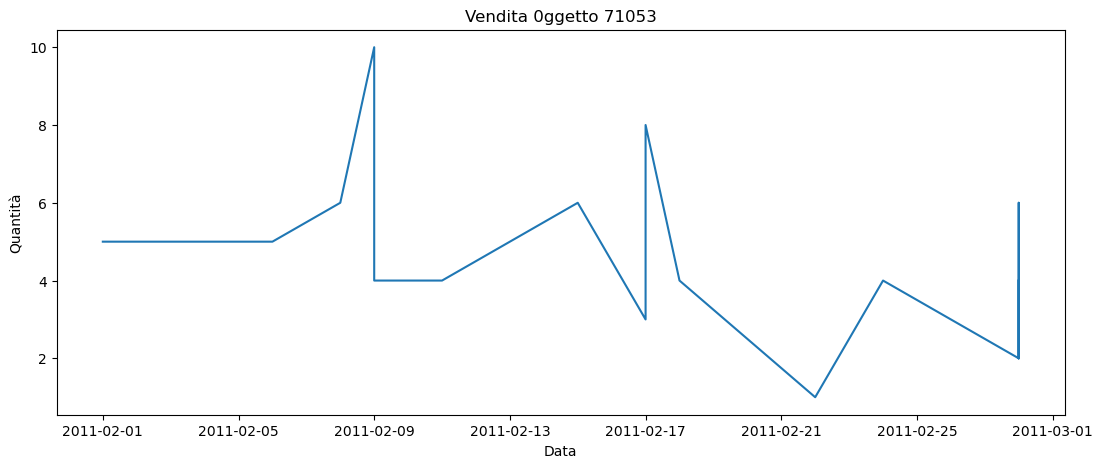

In [47]:
def QtaObjMonth(df, obj, month):
    '''
    QtaObjMonth serve a plottare le vendite di un oggetto durante il mese scelto.
    La funzione richiede:
    df = Dataframe
    obj = Codice dell'articolo
    month = mese dell'anno in cui si vuole vedere gli acquisti, 1 Gennaio - 12 Dicembre
    '''    
    df = df[df["StockCode"] == obj]
    df = df[df["InvoiceDate"].dt.month == month]
    fig, ax = plt.subplots(figsize=(13,5))
    ax.plot(df["Date"], df["Quantity"])
    ax.set(title=f"Vendita 0ggetto {obj}", ylabel="Quantità", xlabel="Data");

QtaObjMonth(df, "71053", 2)


In [48]:
def Top10ObjUser(df, user):
    '''
    TopObjUser serve a plottare i 10 prodotti più acquistati da un determinato cliente.
    La funzione richiede:
    df = Dataframe
    user = CustomerID da analizzare
    '''
    df = df[df["CustomerID"] == user]
    df = df[["StockCode", "Quantity"]]
    df = df.groupby("StockCode")["Quantity"].sum().reset_index()
    df = df.sort_values(by=["Quantity"], ascending=False)
    df = df.head(10)
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(df["StockCode"], df["Quantity"])
    ax.set(title=f"Top prodotti utente: {user}", ylabel="Quantità", xlabel="Prodotto")
    

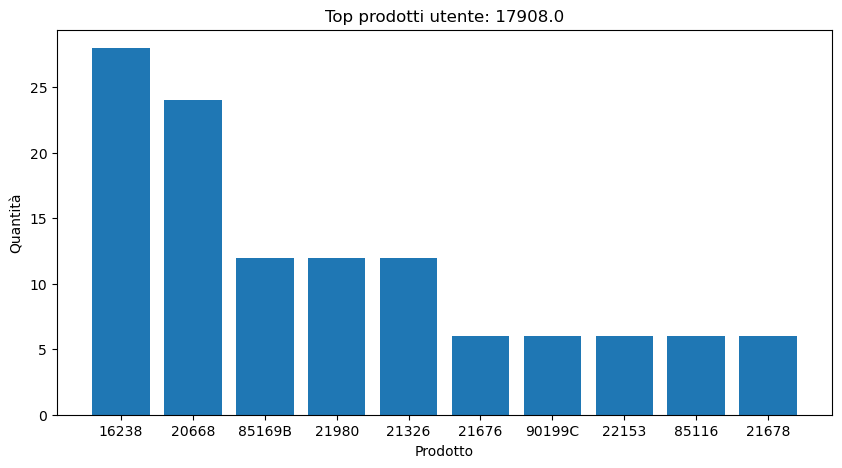

In [49]:
Top10ObjUser(df, 17908.0)

In [50]:
country = df[["Country", "CustomerID"]].copy()

In [51]:
country.drop_duplicates(inplace=True)

In [52]:
country["Total"] = 1

In [53]:
country = country.groupby("Country")["Total"].sum().reset_index()
country = country.sort_values(by="Total", ascending=False)
country = country.head(5)


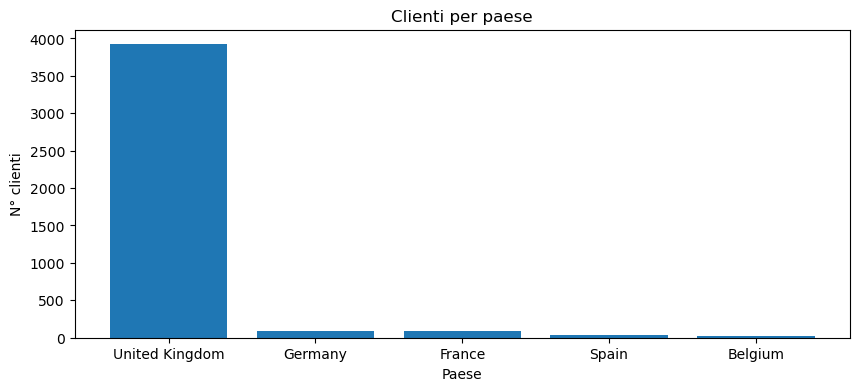

In [54]:
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(country["Country"], country["Total"] );
ax.set(title="Clienti per paese", ylabel="N° clienti", xlabel="Paese");

## Ingegnerizzazione della caratteristiche

### creiamo tre distinti Dataframe che uniremo, li dividiamo secondo il modello RFM (Recency, Frequency e Monetary)

In [55]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


In [56]:
df["Total"] = df["UnitPrice"] * df["Quantity"]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34


In [57]:
df_m = df.groupby("CustomerID")["Total"].sum().reset_index()
df_m.head()

,CustomerID,Total
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1437.24
3,12349.0,1457.55
4,12350.0,294.40


In [58]:
df[df["CustomerID"] == 12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Total
36420,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.6


In [59]:
df_f = df.groupby("CustomerID")["InvoiceNo"].count().reset_index()
df_f.head()

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,182
2,12348.0,27
3,12349.0,72
4,12350.0,16


In [60]:
df_f.rename(columns={"InvoiceNo": "Frequency"}, inplace=True)
df_f.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,27
3,12349.0,72
4,12350.0,16


In [61]:
rfm = df_m.merge(df_f, on="CustomerID")
rfm.head()

,CustomerID,Total,Frequency
0,12346.0,77183.60,1
1,12347.0,4310.00,182
2,12348.0,1437.24,27
3,12349.0,1457.55,72
4,12350.0,294.40,16


In [62]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34


In [63]:
max_date = max(df["Date"])
max_date

datetime.date(2011, 12, 9)

In [64]:
df["Date"] = pd.to_datetime(df["Date"])
max_date = max(df["Date"])
df["Recency"] = (max_date - df["Date"]).dt.days
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Total,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34,373


In [65]:
df_r = df.groupby("CustomerID")["Recency"].min().reset_index()
df_r.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [66]:
rfm = rfm.merge(df_r, on="CustomerID")
rfm.head()

,CustomerID,Total,Frequency,Recency
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,2
2,12348.0,1437.24,27,75
3,12349.0,1457.55,72,18
4,12350.0,294.40,16,310


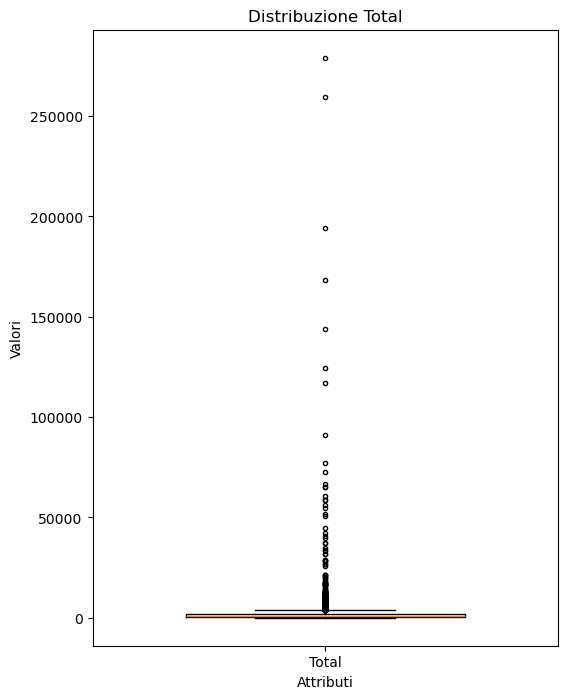

In [67]:
valori1 = ["Total"]
data1 = rfm[valori1]

fig, ax = plt.subplots(figsize=(6,8))
flierprops = dict(marker="o", color="b", markersize=3)
ax.boxplot(data1, labels=valori1, widths = 0.6, flierprops=flierprops)
ax.set(title="Distribuzione Total", xlabel="Attributi", ylabel="Valori");

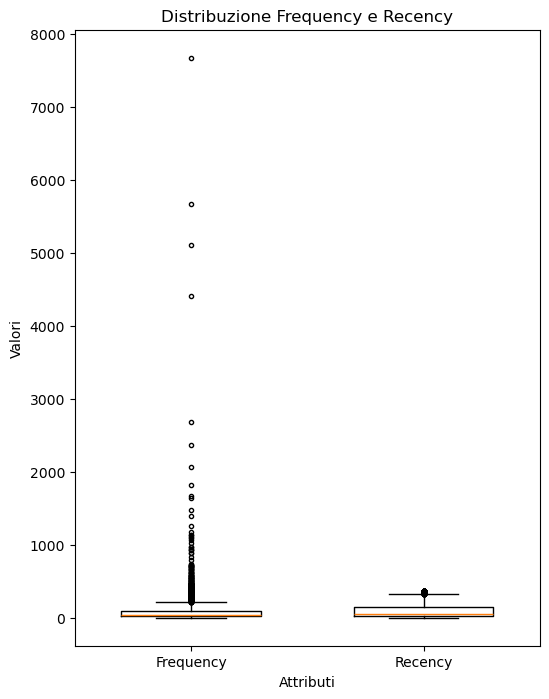

In [68]:
valori2 = ["Frequency", "Recency"]
data2 = rfm[valori2]

fig, ax = plt.subplots(figsize=(6,8))
flierprops = dict(marker="o", color="b", markersize=3)
ax.boxplot(data2, labels=valori2, widths = 0.6, flierprops=flierprops)
ax.set(title="Distribuzione Frequency e Recency", xlabel="Attributi", ylabel="Valori");

In [69]:
Q1 = rfm.Total.quantile(0.05)
Q3 = rfm.Total.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Total >= Q1 - 1.5*IQR) & (rfm.Total <= Q3 + 1.5*IQR)]

Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

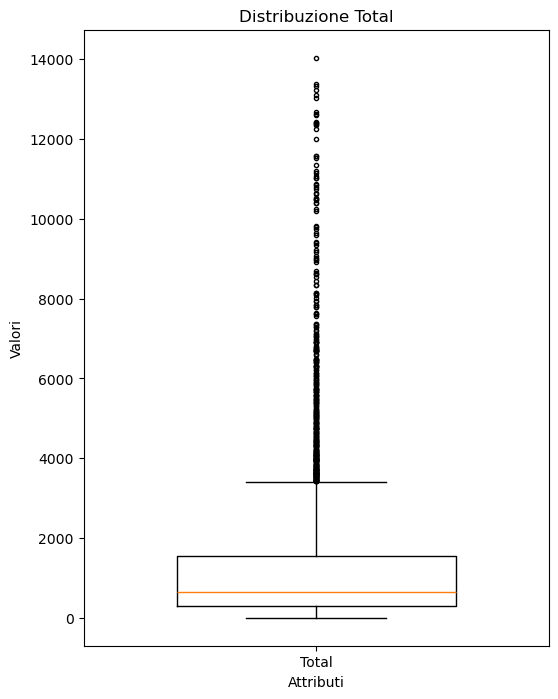

In [70]:
valori1 = ["Total"]
data1 = rfm[valori1]

fig, ax = plt.subplots(figsize=(6,8))
flierprops = dict(marker="o", color="b", markersize=3)
ax.boxplot(data1, labels=valori1, widths = 0.6, flierprops=flierprops)
ax.set(title="Distribuzione Total", xlabel="Attributi", ylabel="Valori");

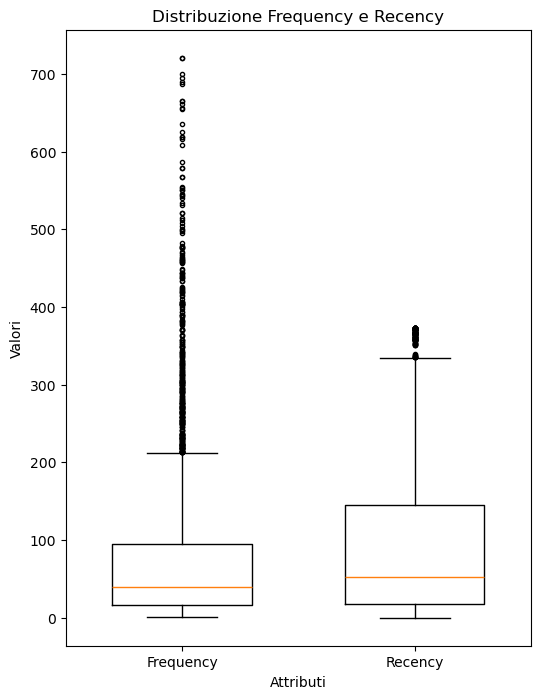

In [71]:
valori2 = ["Frequency", "Recency"]
data2 = rfm[valori2]

fig, ax = plt.subplots(figsize=(6,8))
flierprops = dict(marker="o", color="b", markersize=3)
ax.boxplot(data2, labels=valori2, widths = 0.6, flierprops=flierprops)
ax.set(title="Distribuzione Frequency e Recency", xlabel="Attributi", ylabel="Valori");

## Scaling dei valori

Questa operazione viene fatta per avere delle scale compatibili tra di loro.
Breve accenno teorico, StandardScaler calcola la media e la deviazione standard di ciascuna caratteristica.
la formula è la seguente: z=(x-μ)/σ
​con σ = deviazione standard
μ = media
x = valore della caratteristica

In [72]:
rfm_back = rfm.copy()

In [73]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ["Total", "Frequency", "Recency"]

scaler = StandardScaler()

rfm[columns_to_scale] = scaler.fit_transform(rfm[columns_to_scale])

In [74]:
rfm

,CustomerID,Total,Frequency,Recency
1,12347.0,1.689663,1.087371,-0.913418
2,12348.0,0.077064,-0.495713,-0.184819
3,12349.0,0.088464,-0.036108,-0.753725
4,12350.0,-0.564460,-0.608061,2.160669
5,12352.0,0.519850,0.045599,-0.574071
...,...,...,...,...
4333,18280.0,-0.628341,-0.669342,1.831302
4334,18281.0,-0.684351,-0.699982,0.863165
4335,18282.0,-0.629772,-0.648915,-0.863514
4336,18283.0,0.418522,6.592418,-0.903437


In [75]:
rfm.rename(columns={"Total": "Monetary"}, inplace=True)
rfm.head()

,CustomerID,Monetary,Frequency,Recency
1,12347.0,1.689663,1.087371,-0.913418
2,12348.0,0.077064,-0.495713,-0.184819
3,12349.0,0.088464,-0.036108,-0.753725
4,12350.0,-0.564460,-0.608061,2.160669
5,12352.0,0.519850,0.045599,-0.574071


## Creazione del modello

In [76]:
from sklearn.cluster import KMeans

range = [2,3,4,5,6,7,8,9,10]
ssd = []

X = rfm.drop("CustomerID", axis=1)

for num_clusters in range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X)
    
    ssd.append(kmeans.inertia_)
    print(f"Per {num_clusters} cluster lo score è {kmeans.inertia_}")


Per 2 cluster lo score è 8662.97805591884
Per 3 cluster lo score è 4416.056818763732
Per 4 cluster lo score è 3349.424317797139
Per 5 cluster lo score è 2781.419554270091
Per 6 cluster lo score è 2429.584817517636
Per 7 cluster lo score è 2037.1136996199168
Per 8 cluster lo score è 1855.870647973351
Per 9 cluster lo score è 1665.0305722044752
Per 10 cluster lo score è 1545.6653761899404


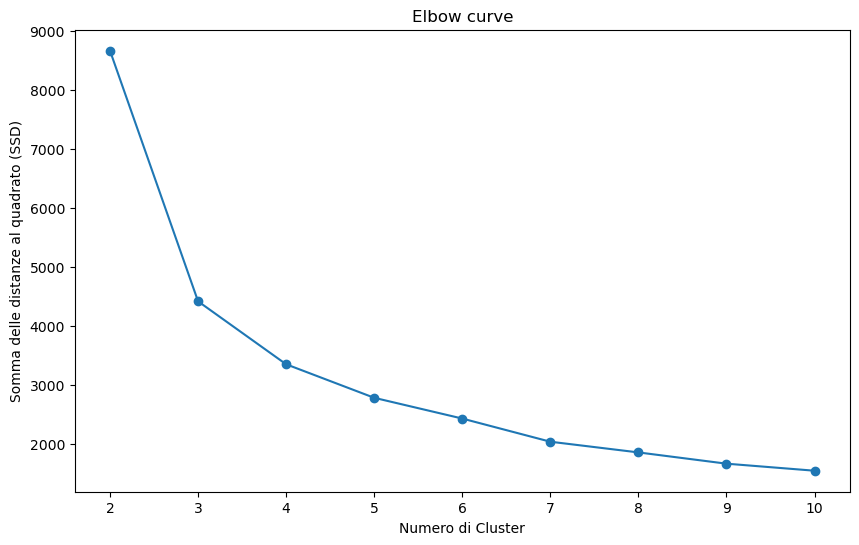

In [77]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range, ssd, marker="o")
ax.set(title="Elbow curve", xlabel="Numero di Cluster", ylabel="Somma delle distanze al quadrato (SSD)");

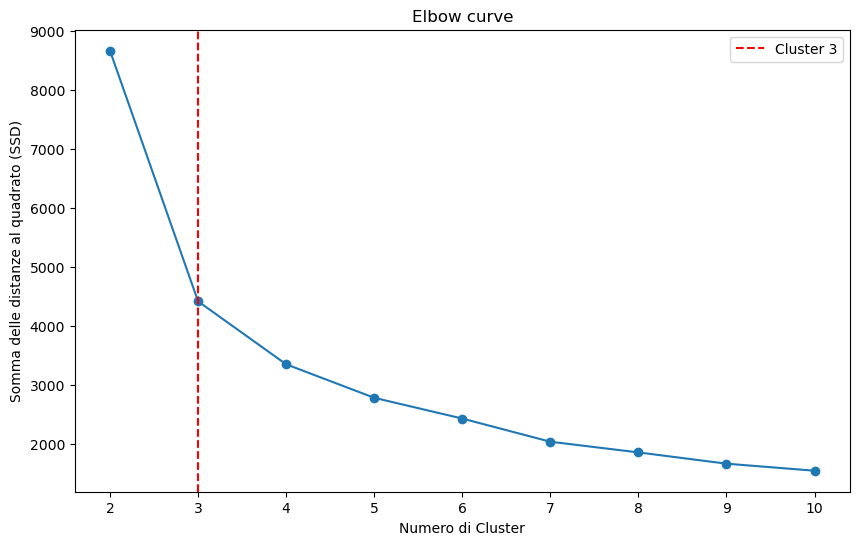

In [78]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range, ssd, marker="o")
ax.set(title="Elbow curve", xlabel="Numero di Cluster", ylabel="Somma delle distanze al quadrato (SSD)")
plt.axvline(x=3, color="r", linestyle="--", label="Cluster 3");
plt.legend();

In [79]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for num_clusters in range:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=42)
    kmeans.fit(X)
    
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Per {num_clusters} cluster il silhouette score è {silhouette_avg}")


Per 2 cluster il silhouette score è 0.40187250278384495
Per 3 cluster il silhouette score è 0.5093394731844885
Per 4 cluster il silhouette score è 0.4864030110987924
Per 5 cluster il silhouette score è 0.4681838368332705
Per 6 cluster il silhouette score è 0.44227966479891023
Per 7 cluster il silhouette score è 0.41525043878452345
Per 8 cluster il silhouette score è 0.3935507665971748
Per 9 cluster il silhouette score è 0.37347215665808825
Per 10 cluster il silhouette score è 0.34293444891659913


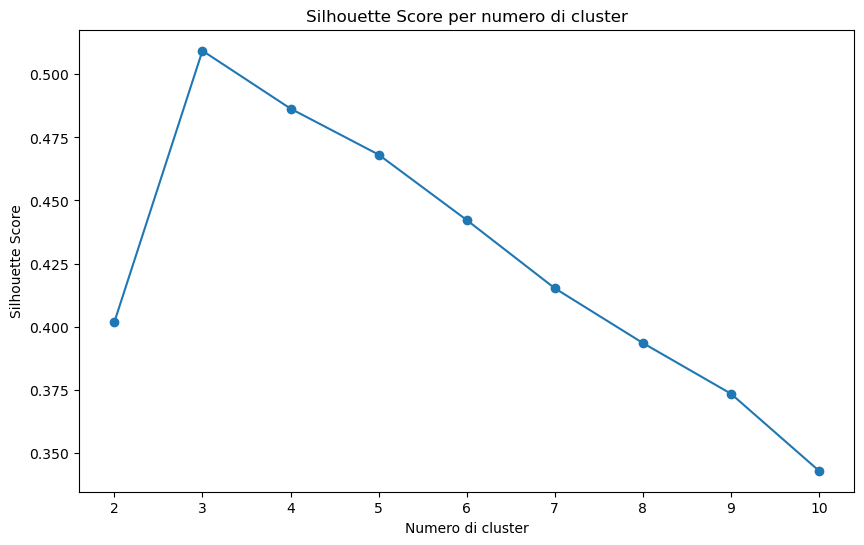

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(range, silhouette_scores, marker="o", linestyle="-")
plt.title("Silhouette Score per numero di cluster")
plt.xlabel("Numero di cluster")
plt.ylabel("Silhouette Score")
plt.show()

In [81]:
"""
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

range = [2,3,4,5,6,7,8,9,10]
silhouette_scores = []

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
ax = ax.flatten()

for num_clusters in range:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=42)
    kmeans.fit(X)
    
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Per {num_clusters} cluster il silhouette score è {silhouette_avg}")

    visualizer = SilhouetteVisualizer(kmeans, colors=sns.color_palette("pastel"), ax=ax[num_clusters])
    visualizer.fit(X)

"""

'\nfrom sklearn.metrics import silhouette_score\nfrom yellowbrick.cluster import SilhouetteVisualizer\n\nrange = [2,3,4,5,6,7,8,9,10]\nsilhouette_scores = []\n\nfig, ax = plt.subplots(3, 2, figsize=(15, 15))\nax = ax.flatten()\n\nfor num_clusters in range:\n    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=42)\n    kmeans.fit(X)\n    \n    cluster_labels = kmeans.labels_\n    silhouette_avg = silhouette_score(X, cluster_labels)\n    silhouette_scores.append(silhouette_avg)\n    print(f"Per {num_clusters} cluster il silhouette score è {silhouette_avg}")\n\n    visualizer = SilhouetteVisualizer(kmeans, colors=sns.color_palette("pastel"), ax=ax[num_clusters])\n    visualizer.fit(X)\n\n'

## Modello finale

In [82]:
kmeans = KMeans(n_clusters=3, max_iter=50, random_state=42)
kmeans.fit(X)

X["Cluster"] = kmeans.labels_
X.head()

,Monetary,Frequency,Recency,Cluster
1,1.689663,1.087371,-0.913418,2
2,0.077064,-0.495713,-0.184819,0
3,0.088464,-0.036108,-0.753725,0
4,-0.564460,-0.608061,2.160669,1
5,0.519850,0.045599,-0.574071,0


In [83]:
cluster = X.copy()
cluster["Total"] = 1

In [84]:
cluster = cluster.groupby("Cluster")["Total"].count().reset_index()

In [85]:
cluster

,Cluster,Total
0,0,2713
1,1,1053
2,2,491


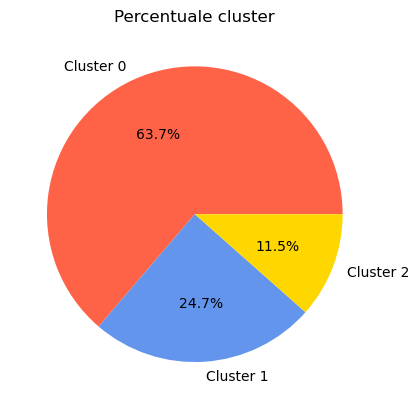

In [86]:
label = ["Cluster 0", "Cluster 1", "Cluster 2"]

fig, ax = plt.subplots()
ax.pie(cluster["Total"], labels=label, autopct="%1.1f%%", colors=["tomato", "cornflowerblue", "gold"]);
ax.set(title="Percentuale cluster");

In [87]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

test = X.drop("Cluster", axis=1)
clusters = X["Cluster"]

s_score = silhouette_score(X, clusters)
c_score = calinski_harabasz_score(X, clusters)
d_score = davies_bouldin_score(X, clusters)

print(f"Silhouette Score: {s_score}")
print(f"Calinski Harabasz Score: {c_score}")
print(f"Davies Bouldin Score: {d_score}")

Silhouette Score: 0.5771029681348092
Calinski Harabasz Score: 5008.770628595688
Davies Bouldin Score: 0.6373852191635594


In [88]:
rfm_back["Cluster"] = X["Cluster"]
rfm_back.head()

,CustomerID,Total,Frequency,Recency,Cluster
1,12347.0,4310.00,182,2,2
2,12348.0,1437.24,27,75,0
3,12349.0,1457.55,72,18,0
4,12350.0,294.40,16,310,1
5,12352.0,2226.04,80,36,0


## Insight dai cluster

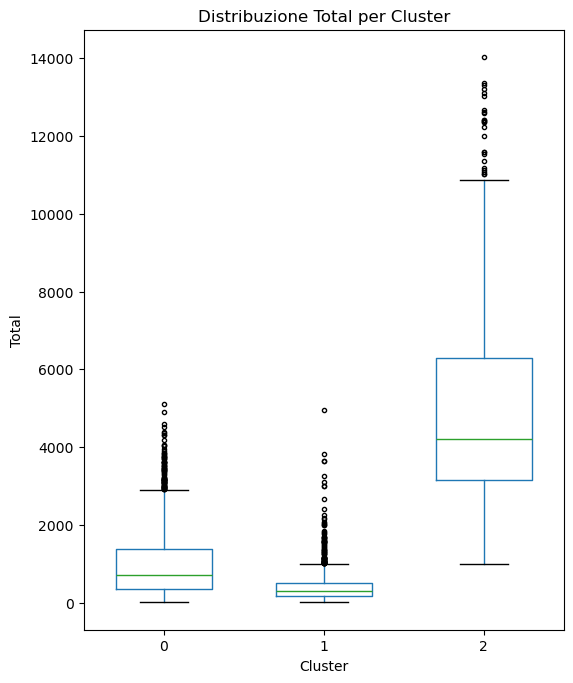

In [117]:
fig, ax = plt.subplots(figsize=(6, 8))
flierprops = dict(marker="o", color="b", markersize=3)
rfm_back.boxplot(column="Total", by="Cluster", ax=ax, widths=0.6, flierprops=flierprops)
ax.set(title="Distribuzione Total per Cluster", xlabel="Cluster", ylabel="Total")
ax.grid(False)
plt.suptitle('');

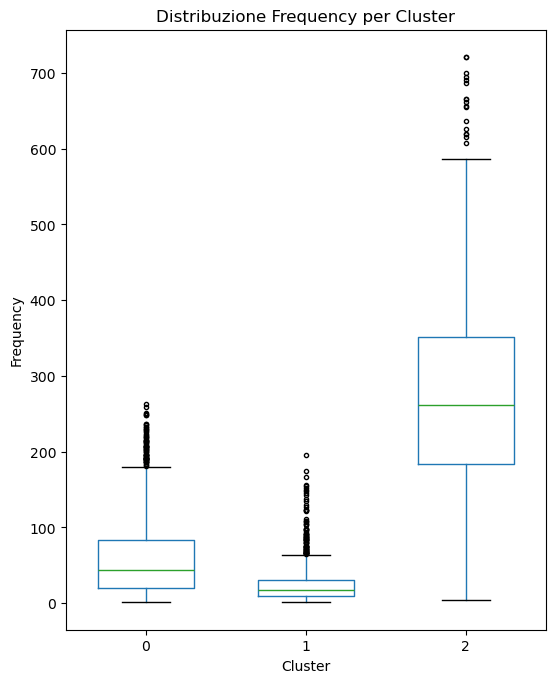

In [118]:
fig, ax = plt.subplots(figsize=(6, 8))
flierprops = dict(marker="o", color="b", markersize=3)
rfm_back.boxplot(column="Frequency", by="Cluster", ax=ax, widths=0.6, flierprops=flierprops)
ax.set(title="Distribuzione Frequency per Cluster", xlabel="Cluster", ylabel="Frequency")
ax.grid(False)
plt.suptitle('');

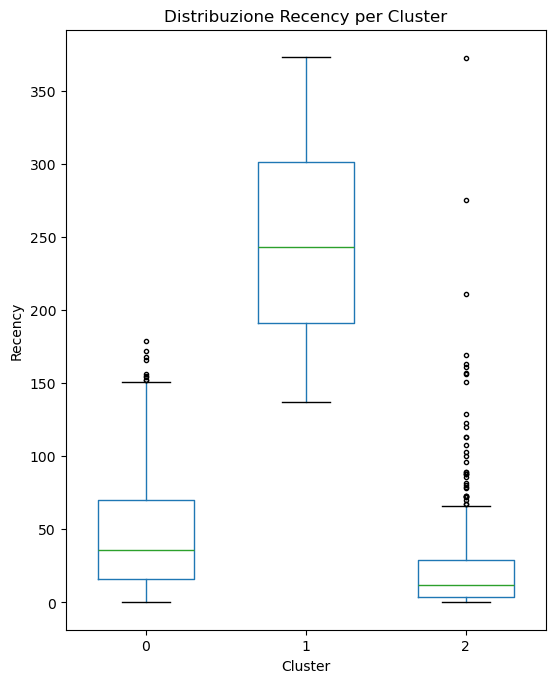

In [119]:
fig, ax = plt.subplots(figsize=(6, 8))
flierprops = dict(marker="o", color="b", markersize=3)
rfm_back.boxplot(column="Recency", by="Cluster", ax=ax, widths=0.6, flierprops=flierprops)
ax.set(title="Distribuzione Recency per Cluster", xlabel="Cluster", ylabel="Recency")
ax.grid(False)
plt.suptitle('');

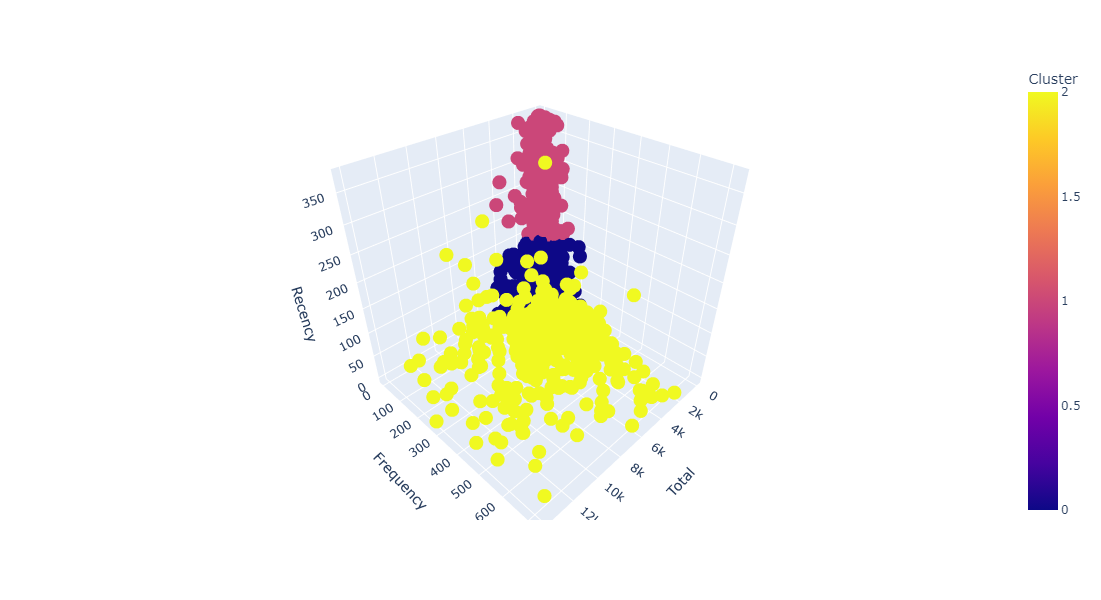

In [104]:
import plotly.express as px

fig = px.scatter_3d(rfm_back, x="Total", y="Frequency", z="Recency",
              color="Cluster")
fig.update_layout(
    width=1000,
    height=600
)
fig.show()

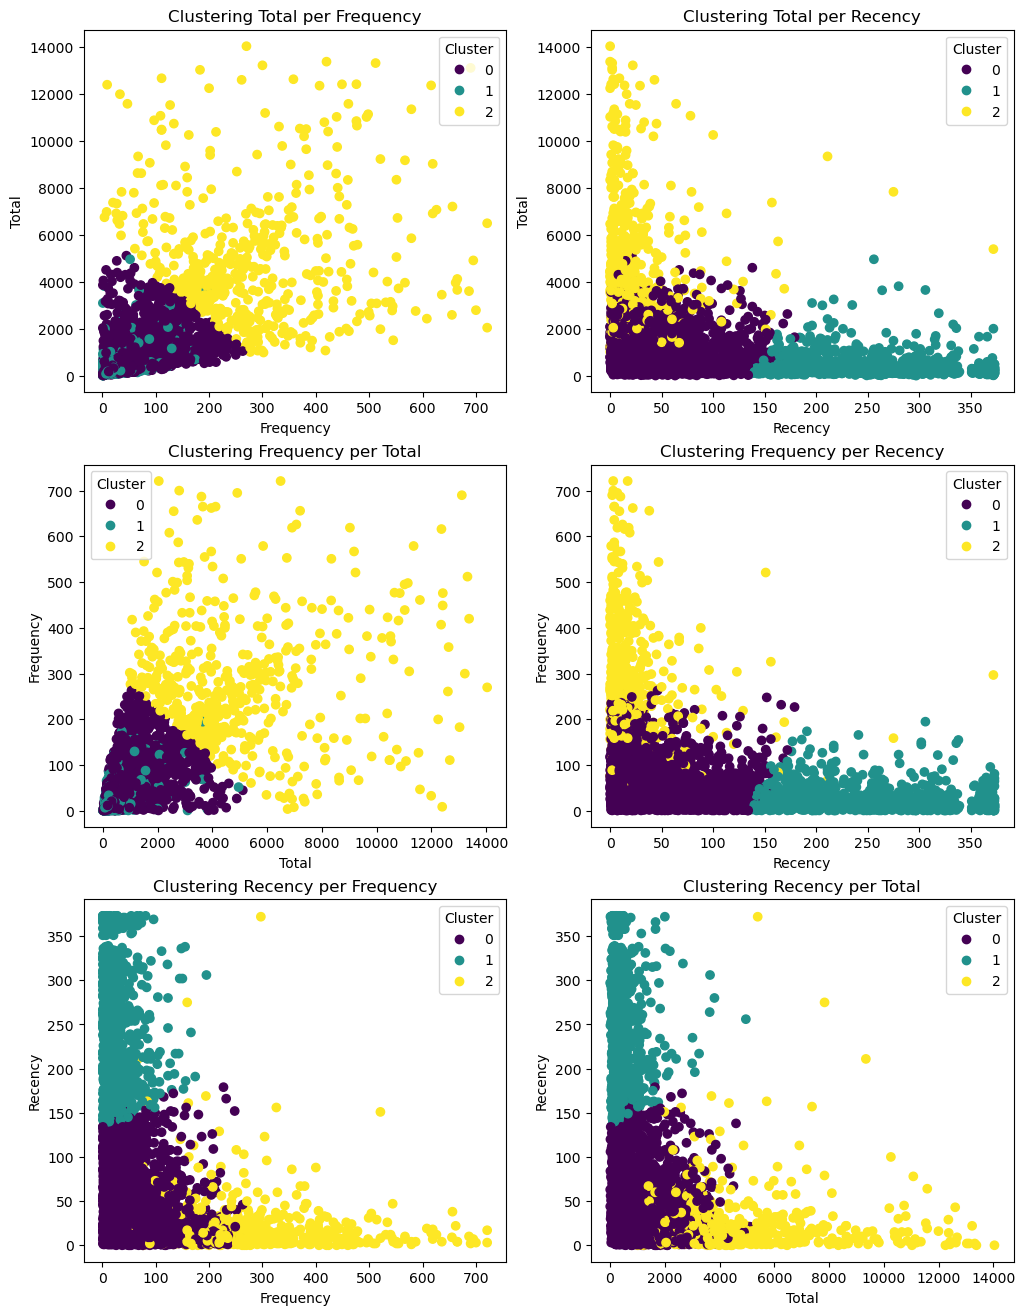

In [116]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(12,16))

scatter1 = ax1.scatter(rfm_back["Frequency"], rfm_back["Total"], c=rfm_back["Cluster"])
ax1.set(title="Clustering Total per Frequency", xlabel="Frequency", ylabel="Total")
scatter2 = ax2.scatter(rfm_back["Recency"], rfm_back["Total"], c=rfm_back["Cluster"])
ax2.set(title="Clustering Total per Recency", xlabel="Recency", ylabel="Total")

scatter3 = ax3.scatter(rfm_back["Total"], rfm_back["Frequency"], c=rfm_back["Cluster"])
ax3.set(title="Clustering Frequency per Total", xlabel="Total", ylabel="Frequency")
scatter4 = ax4.scatter(rfm_back["Recency"], rfm_back["Frequency"], c=rfm_back["Cluster"])
ax4.set(title="Clustering Frequency per Recency", xlabel="Recency", ylabel="Frequency")

scatter5 = ax5.scatter(rfm_back["Frequency"], rfm_back["Recency"], c=rfm_back["Cluster"])
ax5.set(title="Clustering Recency per Frequency", xlabel="Frequency", ylabel="Recency")
scatter6 = ax6.scatter(rfm_back["Total"], rfm_back["Recency"], c=rfm_back["Cluster"])
ax6.set(title="Clustering Recency per Total", xlabel="Total", ylabel="Recency")

handles, labels = scatter1.legend_elements()
ax1.legend(handles, labels, title="Cluster")
ax2.legend(handles, labels, title="Cluster")
ax3.legend(handles, labels, title="Cluster")
ax4.legend(handles, labels, title="Cluster")
ax5.legend(handles, labels, title="Cluster")
ax6.legend(handles, labels, title="Cluster");
